In [12]:
import pandas as pd
import numpy as np
import math
import json
import os
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

from jupyterthemes import jtplot
jtplot.style(theme='solarizedd')
plt.rcParams['figure.figsize'] = (20.0, 10.0)

import data_utils_mt.utils as utils
import seaborn as sns
from sklearn.pipeline import Pipeline
import datetime as dt
from xgboost import XGBClassifier
from sklearn.metrics import mean_squared_error as mse

ROOT_DIR = '../..'
DATA_DIR = os.path.join(ROOT_DIR, 'data')
DATA_RAW = os.path.join(DATA_DIR, 'raw')
DATA_INTERIM = os.path.join(DATA_DIR, 'interim')
DATA_EXTERNAL = os.path.join(DATA_DIR, 'external')
DATA_PROCESSED = os.path.join(DATA_DIR, 'processed')
SRC = os.path.join(ROOT_DIR, 'src')

STATIC_DATASET_PATH = os.path.join(DATA_INTERIM, 'static_data.pkl')

import sys
sys.path.append(SRC)

import src.data.preprocessing as pp
import src.data.success_dataset as sd
import src.data.missing_data as md
import src.evaluation.offer_success as evos
import src.data.profit_10_days_dataset as p10
import src.visualization.visualize as vis

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
static_data = pd.read_pickle(STATIC_DATASET_PATH)
static_data.head()

,person,time,offer_id,age,became_member_on,gender,income,missing_demographics,member_epoch_days,difficulty,...,expected_finish,finish,success,view_time,viewed,actual_reward,profit_in_duration,profit_until_complete,spent_in_duration,spent_until_complete
0,0009655768c64bdeb2e877511632db8f,168,5a8bc65990b245e5a138643cd4eb9837,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,240.0,240.0,0,192.0,1,0.0,22.16,22.16,22.16,22.16
1,0009655768c64bdeb2e877511632db8f,336,3f207df678b143eea3cee63160fa8bed,33.0,2017-04-21,M,72000.0,0,17277,0.0,...,432.0,432.0,0,372.0,1,0.0,8.57,8.57,8.57,8.57
2,0009655768c64bdeb2e877511632db8f,408,f19421c1d4aa40978ebb69ca19b0e20d,33.0,2017-04-21,M,72000.0,0,17277,5.0,...,528.0,414.0,0,NaN,0,5.0,17.68,3.57,22.68,8.57
3,0009655768c64bdeb2e877511632db8f,504,fafdcd668e3743c1bb461111dcafc2a4,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,744.0,528.0,0,NaN,0,2.0,94.87,12.11,96.87,14.11
4,0009655768c64bdeb2e877511632db8f,576,2906b810c7d4411798c6938adc9daaa5,33.0,2017-04-21,M,72000.0,0,17277,10.0,...,744.0,576.0,0,NaN,0,2.0,67.20,8.27,69.20,10.27


In [3]:
static_data.iloc[:10].to_csv(os.path.join(ROOT_DIR, 'reports', 'static.csv'))

In [4]:
static_data.success.mean()

0.3270055193570801

In [5]:
static_data.viewed.mean()

0.7502523696527131

## Bootstrap Confidence Intervals 
<a href="https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/">source</a>

In this case the test set is taken from a time-split, so it's not reasonable to follow the procedure exactly as described in <a href="https://machinelearningmastery.com/calculate-bootstrap-confidence-intervals-machine-learning-results-python/">source</a>.

In [6]:
# Get the data
X_train, X_test, y_train, y_test, encoder, view_cols, profit_cols =\
p10.get_profit_10_days_data(fill_null=True, 
                        target=['viewed', 'profit_10_days'], drop_offer_id=False)

In [7]:
model = p10.ProfitsPredictor(encoder=encoder, view_cols=view_cols, profit_cols=profit_cols)

In [8]:
from sklearn.utils import resample

n_iterations = 200
bootstrap_fraction = 0.7
train_size = int(X_train.shape[0] * bootstrap_fraction)
test_size = int(X_test.shape[0] * bootstrap_fraction)

xy_train = X_train.join(y_train)
xy_test = X_test.join(y_test)

targets = ['viewed', 'profit_10_days']

In [9]:
scores = list()

for i in range(n_iterations):
    print('Iteration: {}'.format(i))
    train = resample(xy_train, n_samples=train_size)
    test = resample(xy_test, n_samples=test_size)
    
    X_train_sample = train.drop(targets, axis=1)
    y_train_sample = train[targets]
    X_test_sample = test.drop(targets, axis=1)
    y_test_sample = test[targets]
    
    %time model.fit(X_train_sample, y_train_sample)
    y_test_pred = model.predict(X_test_sample)
    scores.append(np.sqrt(mse(y_test_sample['profit_10_days'], y_test_pred)))

Iteration: 0
CPU times: user 1min 21s, sys: 1.26 s, total: 1min 22s
Wall time: 1min 41s
Iteration: 1
CPU times: user 1min 14s, sys: 640 ms, total: 1min 15s
Wall time: 1min 15s
Iteration: 2
CPU times: user 1min 14s, sys: 796 ms, total: 1min 15s
Wall time: 1min 16s
Iteration: 3
CPU times: user 1min 13s, sys: 638 ms, total: 1min 14s
Wall time: 1min 14s
Iteration: 4
CPU times: user 1min 15s, sys: 957 ms, total: 1min 16s
Wall time: 1min 16s
Iteration: 5
CPU times: user 1min 14s, sys: 738 ms, total: 1min 15s
Wall time: 1min 15s
Iteration: 6
CPU times: user 1min 14s, sys: 670 ms, total: 1min 15s
Wall time: 1min 15s
Iteration: 7
CPU times: user 1min 17s, sys: 797 ms, total: 1min 18s
Wall time: 1min 19s
Iteration: 8
CPU times: user 1min 17s, sys: 898 ms, total: 1min 17s
Wall time: 1min 18s
Iteration: 9
CPU times: user 1min 17s, sys: 1.21 s, total: 1min 18s
Wall time: 1min 19s
Iteration: 10
CPU times: user 1min 16s, sys: 706 ms, total: 1min 16s
Wall time: 1min 16s
Iteration: 11
CPU times: user 1

Iteration: 93
CPU times: user 1min 14s, sys: 999 ms, total: 1min 15s
Wall time: 1min 15s
Iteration: 94
CPU times: user 1min 14s, sys: 975 ms, total: 1min 15s
Wall time: 1min 16s
Iteration: 95
CPU times: user 1min 13s, sys: 957 ms, total: 1min 14s
Wall time: 1min 15s
Iteration: 96
CPU times: user 1min 15s, sys: 1.06 s, total: 1min 16s
Wall time: 1min 17s
Iteration: 97
CPU times: user 1min 14s, sys: 968 ms, total: 1min 15s
Wall time: 1min 16s
Iteration: 98
CPU times: user 1min 13s, sys: 779 ms, total: 1min 14s
Wall time: 1min 14s
Iteration: 99
CPU times: user 1min 15s, sys: 771 ms, total: 1min 16s
Wall time: 1min 16s
Iteration: 100
CPU times: user 1min 18s, sys: 1.02 s, total: 1min 19s
Wall time: 1min 19s
Iteration: 101
CPU times: user 1min 18s, sys: 1.08 s, total: 1min 19s
Wall time: 1min 19s
Iteration: 102
CPU times: user 1min 18s, sys: 1.06 s, total: 1min 19s
Wall time: 1min 19s
Iteration: 103
CPU times: user 1min 19s, sys: 1.08 s, total: 1min 20s
Wall time: 1min 20s
Iteration: 104
CP

Iteration: 185
CPU times: user 1min 13s, sys: 338 ms, total: 1min 13s
Wall time: 1min 13s
Iteration: 186
CPU times: user 1min 14s, sys: 567 ms, total: 1min 14s
Wall time: 1min 14s
Iteration: 187
CPU times: user 1min 12s, sys: 443 ms, total: 1min 13s
Wall time: 1min 12s
Iteration: 188
CPU times: user 1min 13s, sys: 648 ms, total: 1min 14s
Wall time: 1min 14s
Iteration: 189
CPU times: user 1min 13s, sys: 657 ms, total: 1min 14s
Wall time: 1min 14s
Iteration: 190
CPU times: user 1min 16s, sys: 985 ms, total: 1min 17s
Wall time: 1min 19s
Iteration: 191
CPU times: user 1min 16s, sys: 843 ms, total: 1min 17s
Wall time: 1min 18s
Iteration: 192
CPU times: user 1min 16s, sys: 785 ms, total: 1min 17s
Wall time: 1min 19s
Iteration: 193
CPU times: user 1min 14s, sys: 506 ms, total: 1min 15s
Wall time: 1min 15s
Iteration: 194
CPU times: user 1min 16s, sys: 731 ms, total: 1min 17s
Wall time: 1min 17s
Iteration: 195
CPU times: user 1min 16s, sys: 879 ms, total: 1min 17s
Wall time: 1min 18s
Iteration:

In [10]:
# confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0)
lower = np.quantile(scores, p)
p = alpha+ p
upper = np.quantile(scores, p)
print('For {} samples, the {}% confidence interval for RMSE is: [{:.3}, {:.3}]'.format(
n_iterations, alpha*100, lower, upper))

For 200 samples, the 95.0% confidence interval for RMSE is: [62.8, 75.0]


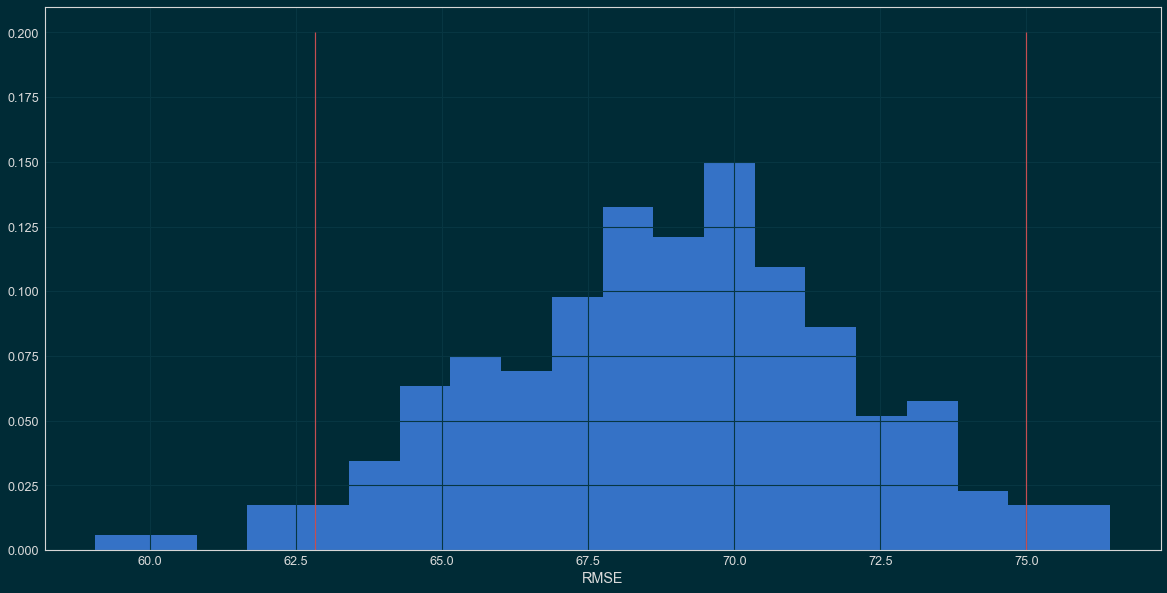

In [13]:
_ = plt.hist(scores, density=1, bins=20)
plt.xlabel('RMSE')
plt.vlines(lower, 0, 0.2, color='r')
plt.vlines(upper, 0, 0.2, color='r')